# Predicting USA Real Estate Prices Using Machine Learning

**Project Report**

Abbad Chamma

---


## 1 Introduction

### 1.1 Problem Statement

It is hard to predict the cost of real estate. These prices depend on numerous factors: location, property size, number and size of bedrooms and bathrooms, and market conditions. In this work, I have built machine learning models capable of predicting the properties prices based on characteristics like location (city, state, zip code), property characteristics (bedrooms, bathrooms, lot size, house size), and listing status.

### 1.2 Motivation and Challenges

The relations between features and prices are not always obvious, making price predictions challenging. While location is a plus, missing data and extreme outliers may strongly bias the results. For this type of problem, it's not possible to use traditional statistical methods; thus, machine learning was employed.

Following are some of the challenges I faced:
- The dataset is large with over 2.2 million samples. This required a careful processing.
- Missing values in house_size and acre_lot columns
- Prices vary significantly depending on location
- Many categorical features (city, state, status) that needed encoding
- Extreme outliers in both price and property size

### 1.3 Approach

I employed two machine learning algorithms:

1. **Random Forest Regressor**: Aggregates numerous decision trees and takes the average of their predictions. Suitable for capturing nonlinear relationships, indicating which features are most important. The averaging prevents overfitting.

2. **XGBoost Regressor**: It builds models in sequence, with each subsequent model trying to correct the errors from the one before it. It generally works well on structured data and automatically handles missing values.

Both algorithms work well on this problem since they are able to find complex relationships, handle categorical variables, and are robust to outliers. I used RMSE, MAE, and R² scores to evaluate prediction quality.

## 2 Data

### 2.1 Dataset Introduction

The dataset used is the USA Real Estate Dataset from Kaggle. It contains property listings from Realtor.com across the United States. There are over 2.2 million listings with 12 features:

- **brokered_by**: Broker/agency ID (encoded)
- **status**: Sale status (for sale, sold, etc.)
- **price**: The price - this is the target variable
- **bed**: Number of bedrooms
- **bath**: Number of bathrooms
- **acre_lot**: Land size in acres
- **street**: Street address (encoded)
- **city**: City name
- **state**: State name
- **zip_code**: Zip code
- **house_size**: House area in square feet
- **prev_sold_date**: Previous sale date (if applicable)

This dataset works well for the project since it has more than 10,000 samples and multiple relevant features.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded")


Libraries loaded


In [2]:
# Load data
df = pd.read_csv('../data/realtor-data.zip.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (2226382, 12)

Column names: ['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state', 'zip_code', 'house_size', 'prev_sold_date']

Data types:
brokered_by       float64
status             object
price             float64
bed               float64
bath              float64
acre_lot          float64
street            float64
city               object
state              object
zip_code          float64
house_size        float64
prev_sold_date     object
dtype: object

First few rows:


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [3]:
# Check dataset info
print("Dataset Info:")
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"\nMissing values per column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)


Dataset Info:
Total samples: 2,226,382
Total features: 12

Missing values per column:
                Missing Count  Percentage
prev_sold_date         734297   32.981627
house_size             568484   25.533983
bath                   511771   22.986666
bed                    481317   21.618797
acre_lot               325589   14.624130
street                  10866    0.488056
brokered_by              4533    0.203604
price                    1541    0.069215
city                     1407    0.063197
zip_code                  299    0.013430
state                       8    0.000359


In [4]:
# Stats summary
print("Statistical Summary of Numerical Features:")
df.describe()


Statistical Summary of Numerical Features:


,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


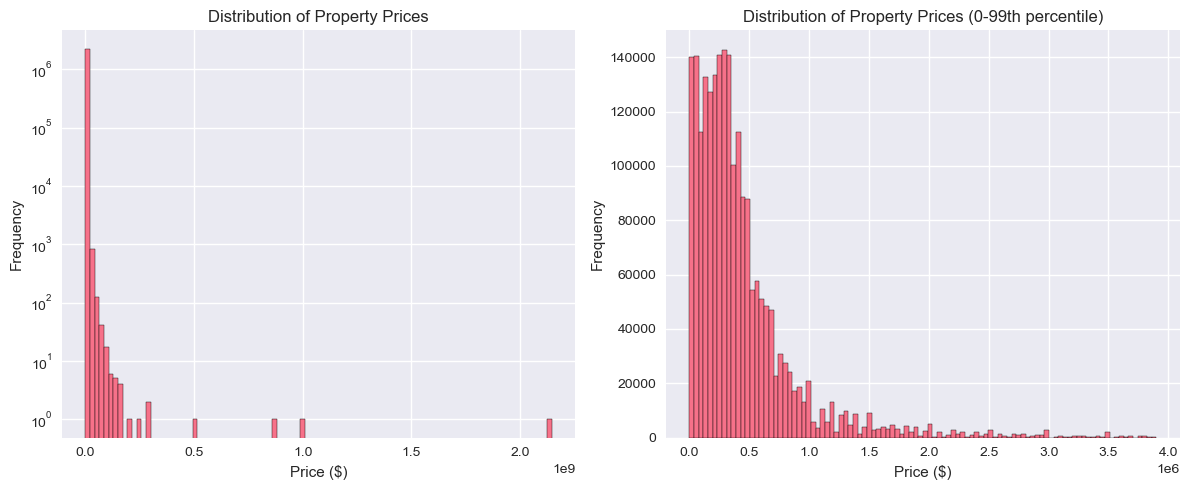

Price statistics:
Mean: $524,195.52
Median: $325,000.00
Min: $0.00
Max: $2,147,483,600.00


In [5]:
# Price distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['price'].dropna(), bins=100, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Property Prices')
plt.yscale('log')

plt.subplot(1, 2, 2)
# Remove outliers for plotting
price_clean = df['price'].dropna()
price_clean = price_clean[(price_clean > 0) & (price_clean < price_clean.quantile(0.99))]
plt.hist(price_clean, bins=100, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Property Prices (0-99th percentile)')

plt.tight_layout()
plt.show()

print(f"Price statistics:")
print(f"Mean: ${df['price'].mean():,.2f}")
print(f"Median: ${df['price'].median():,.2f}")
print(f"Min: ${df['price'].min():,.2f}")
print(f"Max: ${df['price'].max():,.2f}")


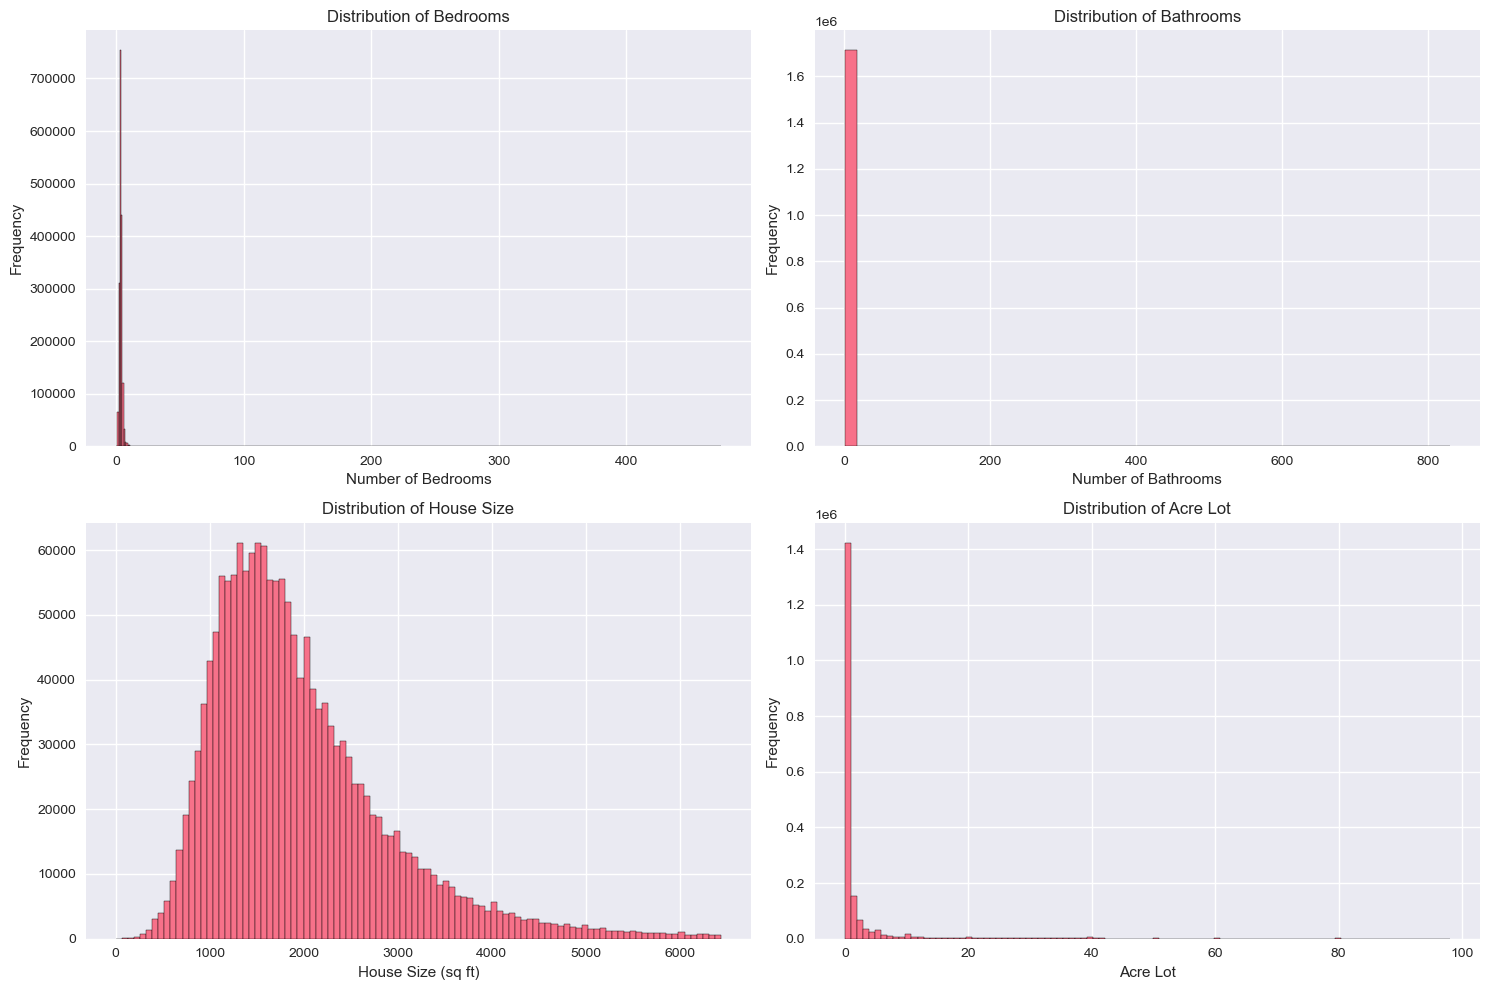

In [6]:
# Feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bedroom distribution
axes[0, 0].hist(df['bed'].dropna(), bins=range(0, int(df['bed'].max())+2), edgecolor='black')
axes[0, 0].set_xlabel('Number of Bedrooms')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Bedrooms')

# Bathroom distribution
axes[0, 1].hist(df['bath'].dropna(), bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Number of Bathrooms')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Bathrooms')

# House size (no outliers)
house_size_clean = df['house_size'].dropna()
house_size_clean = house_size_clean[(house_size_clean > 0) & (house_size_clean < house_size_clean.quantile(0.99))]
axes[1, 0].hist(house_size_clean, bins=100, edgecolor='black')
axes[1, 0].set_xlabel('House Size (sq ft)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of House Size')

# Acre lot (no outliers)
acre_clean = df['acre_lot'].dropna()
acre_clean = acre_clean[(acre_clean > 0) & (acre_clean < acre_clean.quantile(0.99))]
axes[1, 1].hist(acre_clean, bins=100, edgecolor='black')
axes[1, 1].set_xlabel('Acre Lot')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Acre Lot')

plt.tight_layout()
plt.show()


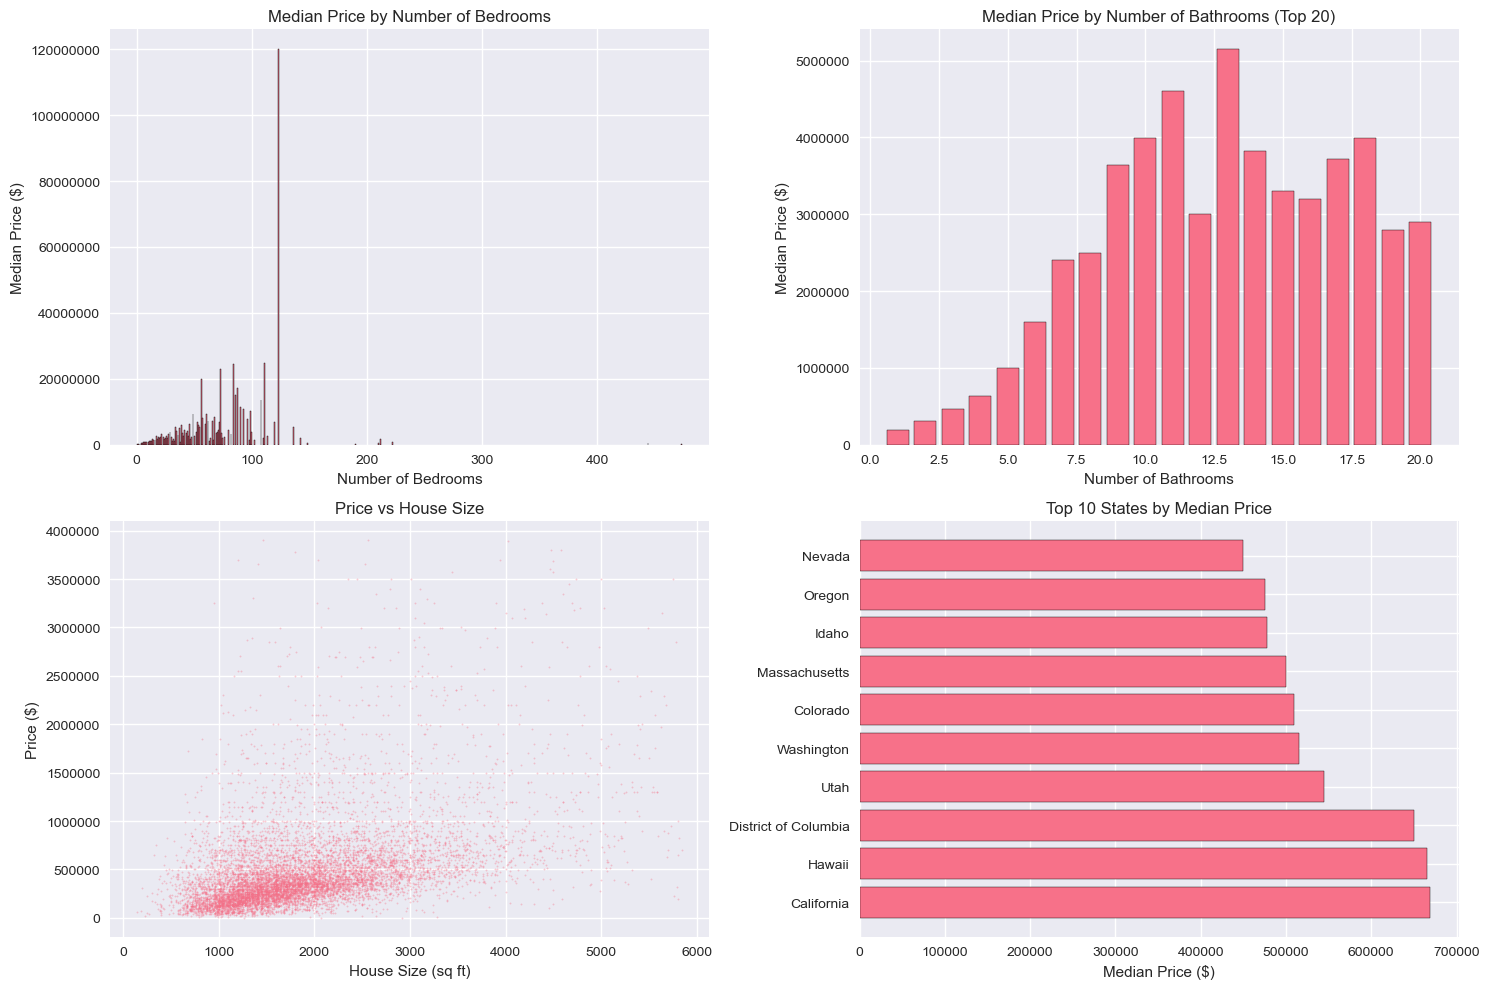

In [7]:
# Price relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price by bedrooms
bed_price = df.groupby('bed')['price'].median().dropna()
axes[0, 0].bar(bed_price.index, bed_price.values, edgecolor='black')
axes[0, 0].set_xlabel('Number of Bedrooms')
axes[0, 0].set_ylabel('Median Price ($)')
axes[0, 0].set_title('Median Price by Number of Bedrooms')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Price by bathrooms
bath_price = df.groupby('bath')['price'].median().dropna()
axes[0, 1].bar(bath_price.index[:20], bath_price.values[:20], edgecolor='black')
axes[0, 1].set_xlabel('Number of Bathrooms')
axes[0, 1].set_ylabel('Median Price ($)')
axes[0, 1].set_title('Median Price by Number of Bathrooms (Top 20)')
axes[0, 1].ticklabel_format(style='plain', axis='y')

# Price vs house size
sample_df = df[['house_size', 'price']].dropna()
sample_df = sample_df[(sample_df['price'] > 0) & (sample_df['price'] < sample_df['price'].quantile(0.99))]
sample_df = sample_df[(sample_df['house_size'] > 0) & (sample_df['house_size'] < sample_df['house_size'].quantile(0.99))]
sample_df = sample_df.sample(min(10000, len(sample_df)))
axes[1, 0].scatter(sample_df['house_size'], sample_df['price'], alpha=0.3, s=1)
axes[1, 0].set_xlabel('House Size (sq ft)')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Price vs House Size')
axes[1, 0].ticklabel_format(style='plain', axis='y')

# States by price
state_price = df.groupby('state')['price'].median().sort_values(ascending=False).head(10)
axes[1, 1].barh(range(len(state_price)), state_price.values, edgecolor='black')
axes[1, 1].set_yticks(range(len(state_price)))
axes[1, 1].set_yticklabels(state_price.index)
axes[1, 1].set_xlabel('Median Price ($)')
axes[1, 1].set_title('Top 10 States by Median Price')
axes[1, 1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


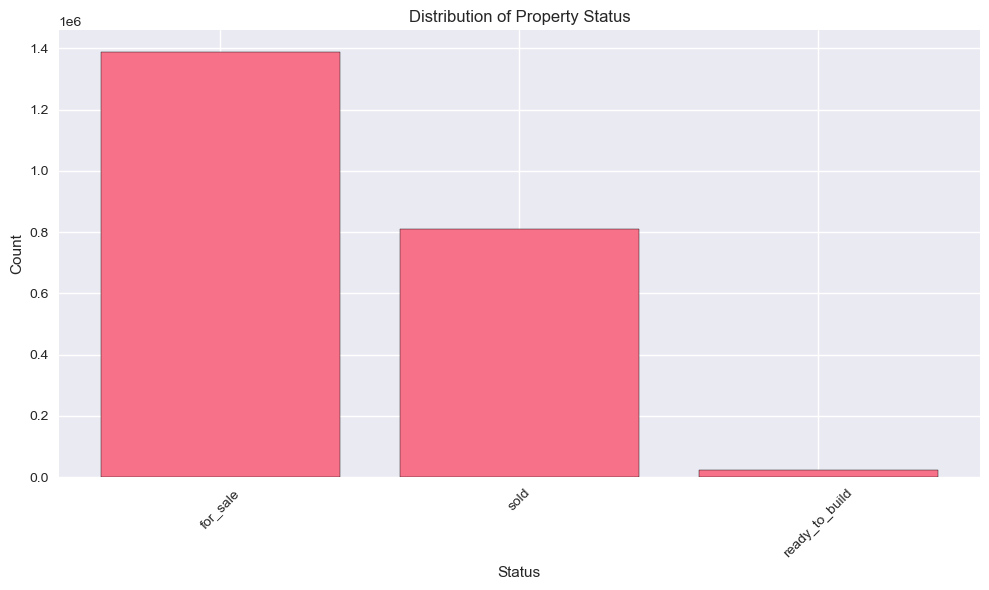

Status distribution:
status
for_sale          1389306
sold               812009
ready_to_build      25067
Name: count, dtype: int64


In [8]:
# Status breakdown
status_counts = df['status'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(status_counts.index, status_counts.values, edgecolor='black')
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Property Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Status distribution:")
print(status_counts)


In [9]:
# Make a copy to work with
df_processed = df.copy()

print(f"Original dataset shape: {df_processed.shape}")

# Drop rows with no price
df_processed = df_processed.dropna(subset=['price'])
print(f"After removing missing prices: {df_processed.shape}")

# Remove invalid prices
df_processed = df_processed[df_processed['price'] > 0]
print(f"After removing invalid prices: {df_processed.shape}")

# Remove price outliers
price_upper = df_processed['price'].quantile(0.999)
df_processed = df_processed[df_processed['price'] <= price_upper]
print(f"After removing price outliers (99.9th percentile): {df_processed.shape}")


Original dataset shape: (2226382, 12)
After removing missing prices: (2224841, 12)
After removing invalid prices: (2224561, 12)
After removing price outliers (99.9th percentile): (2222353, 12)


In [10]:
# Fill missing values
# Fill house_size
if df_processed['house_size'].isnull().sum() > 0:
    median_house_size = df_processed['house_size'].median()
    df_processed['house_size'].fillna(median_house_size, inplace=True)
    print(f"Filled {df_processed['house_size'].isnull().sum()} missing house_size values with median: {median_house_size}")

# Fill acre_lot
if df_processed['acre_lot'].isnull().sum() > 0:
    median_acre = df_processed['acre_lot'].median()
    df_processed['acre_lot'].fillna(median_acre, inplace=True)
    print(f"Filled {df_processed['acre_lot'].isnull().sum()} missing acre_lot values with median: {median_acre}")

# Fill bed/bath
if df_processed['bed'].isnull().sum() > 0:
    mode_bed = df_processed['bed'].mode()[0]
    df_processed['bed'].fillna(mode_bed, inplace=True)
    print(f"Filled missing bed values with mode: {mode_bed}")

if df_processed['bath'].isnull().sum() > 0:
    mode_bath = df_processed['bath'].mode()[0]
    df_processed['bath'].fillna(mode_bath, inplace=True)
    print(f"Filled missing bath values with mode: {mode_bath}")

print(f"\nRemaining missing values: {df_processed.isnull().sum().sum()}")


Filled 0 missing house_size values with median: 1759.0
Filled 0 missing acre_lot values with median: 0.26
Filled missing bed values with mode: 3.0
Filled missing bath values with mode: 2.0

Remaining missing values: 748944


In [11]:
# Encode categories
# Encode status
status_dummies = pd.get_dummies(df_processed['status'], prefix='status', drop_first=True)
df_processed = pd.concat([df_processed, status_dummies], axis=1)

# Encode states
top_states = df_processed['state'].value_counts().head(20).index
df_processed['state_encoded'] = df_processed['state'].apply(lambda x: x if x in top_states else 'Other')
state_dummies = pd.get_dummies(df_processed['state_encoded'], prefix='state', drop_first=True)
df_processed = pd.concat([df_processed, state_dummies], axis=1)

# Encode cities
city_counts = df_processed['city'].value_counts()
df_processed['city_frequency'] = df_processed['city'].map(city_counts)

# Zip code is already numeric
# Brokered_by already numeric
# Street already numeric

print("Categorical encoding completed!")
print(f"Dataset shape after encoding: {df_processed.shape}")


Categorical encoding completed!
Dataset shape after encoding: (2222353, 36)


## 3 Preprocessing

### 3.1 Data Cleaning and Feature Engineering

The data was cleaned before training. Invalid entries were removed, missing values were handled, and categorical variables were encoded so the models could use them.

In [12]:
# Pick features
# Drop old categorical columns
features_to_drop = ['status', 'state', 'city', 'state_encoded', 'prev_sold_date']
feature_columns = [col for col in df_processed.columns if col not in features_to_drop and col != 'price']

X = df_processed[feature_columns]
y = df_processed['price']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nSelected features: {feature_columns}")


Feature matrix shape: (2222353, 30)
Target vector shape: (2222353,)

Selected features: ['brokered_by', 'bed', 'bath', 'acre_lot', 'street', 'zip_code', 'house_size', 'status_ready_to_build', 'status_sold', 'state_California', 'state_Florida', 'state_Georgia', 'state_Illinois', 'state_Maryland', 'state_Michigan', 'state_Minnesota', 'state_Missouri', 'state_New Jersey', 'state_New York', 'state_North Carolina', 'state_Ohio', 'state_Other', 'state_Pennsylvania', 'state_South Carolina', 'state_Tennessee', 'state_Texas', 'state_Virginia', 'state_Washington', 'state_Wisconsin', 'city_frequency']


In [13]:
# Fill any remaining NaNs
X = X.fillna(0)

# Split train/test
# Sample data for speed
sample_size = min(500000, len(X))  # Use up to 500k samples
if sample_size < len(X):
    X_sample = X.sample(n=sample_size, random_state=42)
    y_sample = y.loc[X_sample.index]
else:
    X_sample = X
    y_sample = y

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]:,}")
print(f"Test set size: {X_test.shape[0]:,}")
print(f"Number of features: {X_train.shape[1]}")


Training set size: 400,000
Test set size: 100,000
Number of features: 30


## 4 Methods

### 4.1 Random Forest Regressor

Random Forest fits multiple decision trees and averages their predictions. Each tree is trained on a random sample of the data, and when splitting, it only considers a random subset of features. This helps prevent overfitting and enhances stability.

Random Forest was chosen because it can handle non-linear relationships quite well, shows feature importance, and is robust to outliers and missing values. It works for both numerical and categorical features.

For hyperparameters, 100 trees were used and the maximum depth was set to 20. At least 5 samples are required to split a node. random_state=42 was set for reproducibility.

In [14]:
# Train Random Forest
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Get metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Results:")
print(f"RMSE: ${rf_rmse:,.2f}")
print(f"MAE: ${rf_mae:,.2f}")
print(f"R² Score: {rf_r2:.4f}")


Training Random Forest Regressor...

Random Forest Results:
RMSE: $484,438.58
MAE: $183,067.15
R² Score: 0.6102


Top 15 Most Important Features (Random Forest):
                 feature  importance
2                   bath    0.254309
5               zip_code    0.240835
6             house_size    0.127325
3               acre_lot    0.109200
29        city_frequency    0.085928
4                 street    0.058729
0            brokered_by    0.046420
1                    bed    0.026117
10         state_Florida    0.019998
18        state_New York    0.010211
9       state_California    0.004038
8            status_sold    0.003987
21           state_Other    0.003558
23  state_South Carolina    0.001145
25           state_Texas    0.001112


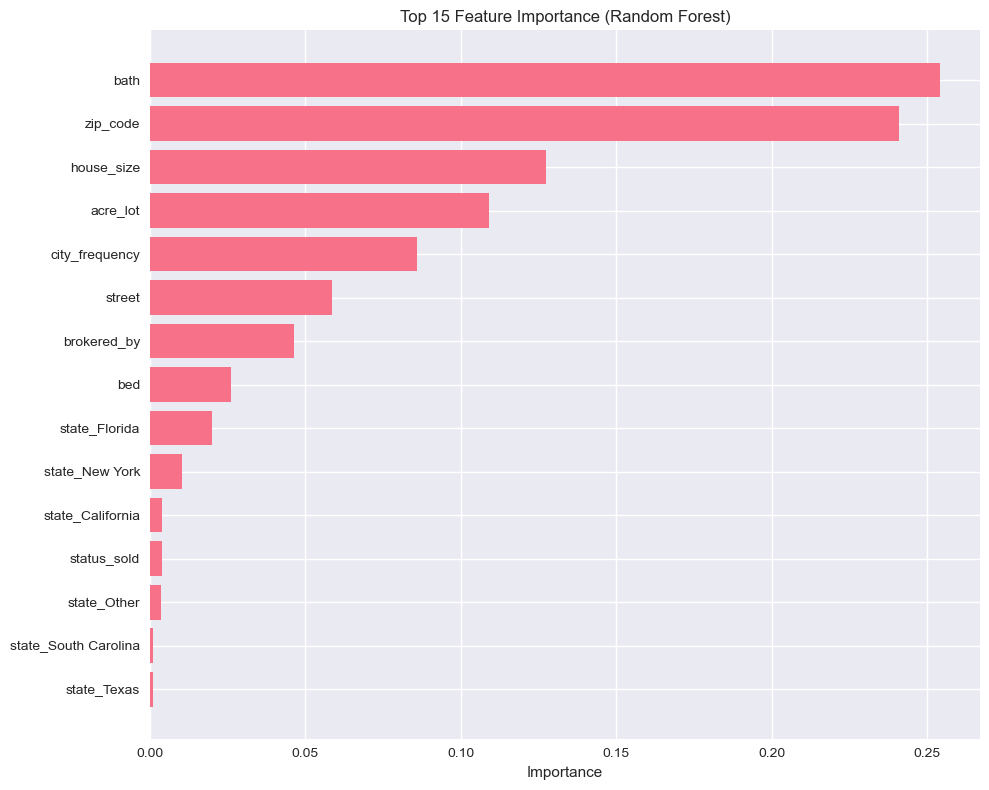

In [22]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features (Random Forest):")
print(feature_importance.head(15))

# Plot importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 4.2 XGBoost Regressor

XGBoost builds models in a sequential manner, with each model trying to correct the errors of the previously built model. It includes regularization to avoid overfitting and handles missing values automatically.

XGBoost was selected here because it generally performs well on tabular/structured data, is very efficient to train, and presents feature importance. The regularization improves the generalization on new data.

For hyperparameters, a total of 100 boosting rounds were made with a maximum depth of 6, the learning rate was set at 0.1, and each tree used 80% of samples. random_state=42 for reproducibility.

In [23]:
# Train XGBoost
print("Training XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Get metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Results:")
print(f"RMSE: ${xgb_rmse:,.2f}")
print(f"MAE: ${xgb_mae:,.2f}")
print(f"R² Score: {xgb_r2:.4f}")


Training XGBoost Regressor...

XGBoost Results:
RMSE: $511,044.62
MAE: $208,885.60
R² Score: 0.5662


Top 15 Most Important Features (XGBoost):
               feature  importance
2                 bath    0.197040
18      state_New York    0.126445
6           house_size    0.094492
10       state_Florida    0.081627
5             zip_code    0.071745
9     state_California    0.061621
29      city_frequency    0.042719
3             acre_lot    0.040523
1                  bed    0.025871
15     state_Minnesota    0.022885
22  state_Pennsylvania    0.022372
8          status_sold    0.022109
27    state_Washington    0.019654
21         state_Other    0.019092
4               street    0.017302


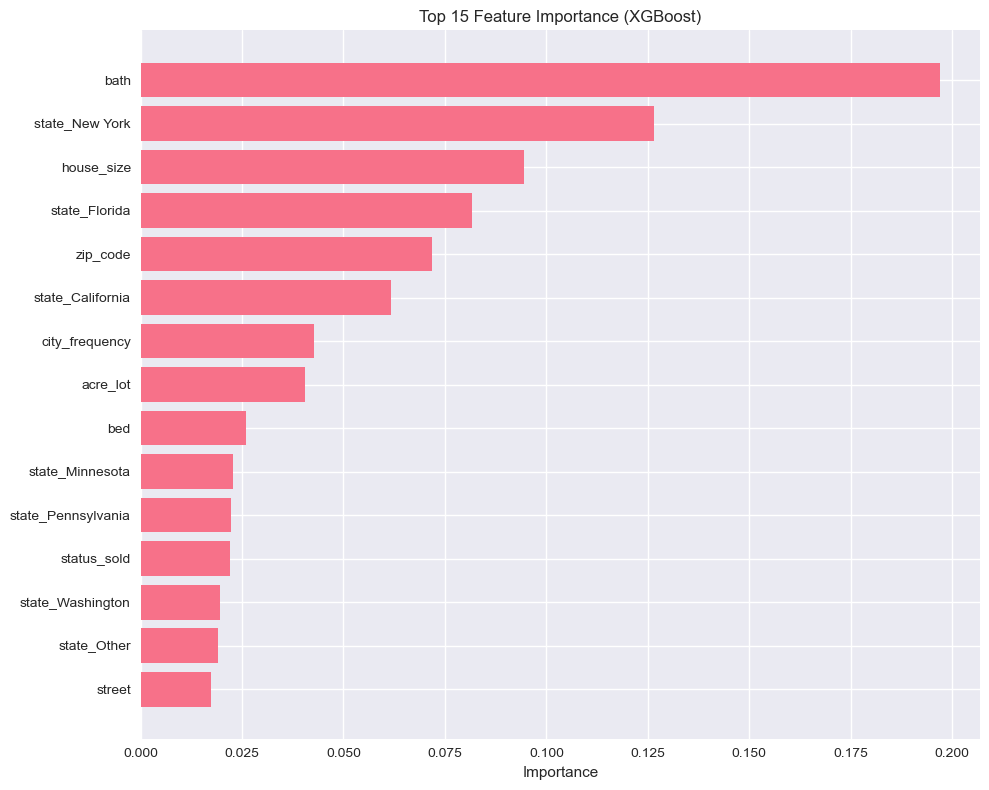

In [24]:
# XGBoost importance
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features (XGBoost):")
print(xgb_importance.head(15))

# Plot importance
plt.figure(figsize=(10, 8))
top_features_xgb = xgb_importance.head(15)
plt.barh(range(len(top_features_xgb)), top_features_xgb['importance'].values)
plt.yticks(range(len(top_features_xgb)), top_features_xgb['feature'].values)
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 5 Results

### 5.1 Experimental Setup

A sample of 500,000 records was used from the full dataset to keep training time reasonable. The data was split 80/20 for training and testing with random seed 42.

For feature engineering, one-hot encoding was used for status and top states, frequency encoding for cities (due to too many unique cities for one-hot encoding), and missing values were filled with median or mode. Both models were trained on the same data for fair comparison.

Evaluation metrics:
- **RMSE**: Average prediction error in dollars (lower is better)
- **MAE**: Average absolute difference between predicted and actual values
- **R² Score**: Proportion of variance explained by the model (1.0 is perfect)

Model Performance Comparison:
        Model          RMSE           MAE  R² Score
Random Forest 484438.576535 183067.153094  0.610214
      XGBoost 511044.616990 208885.596623  0.566223


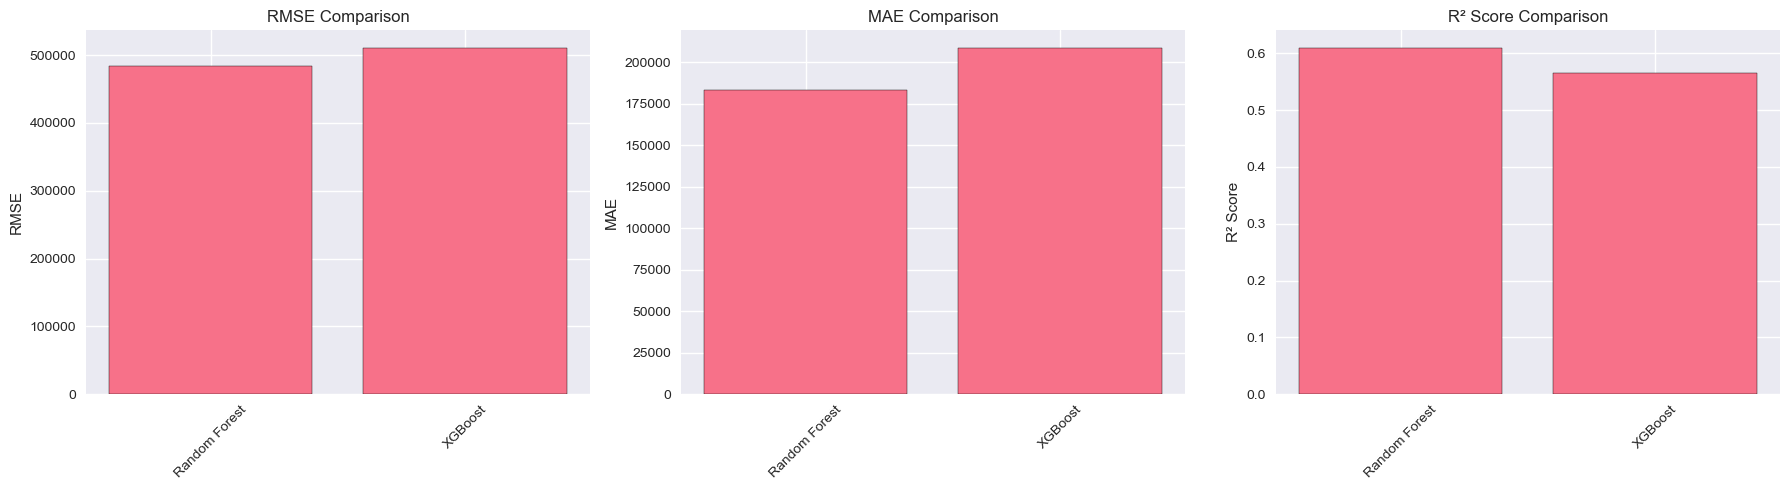

In [25]:
# Compare models
results_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE': [rf_rmse, xgb_rmse],
    'MAE': [rf_mae, xgb_mae],
    'R² Score': [rf_r2, xgb_r2]
})

print("Model Performance Comparison:")
print(results_comparison.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RMSE', 'MAE', 'R² Score']
for i, metric in enumerate(metrics):
    axes[i].bar(results_comparison['Model'], results_comparison[metric], edgecolor='black')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} Comparison')
    if metric != 'R² Score':
        axes[i].ticklabel_format(style='plain', axis='y')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


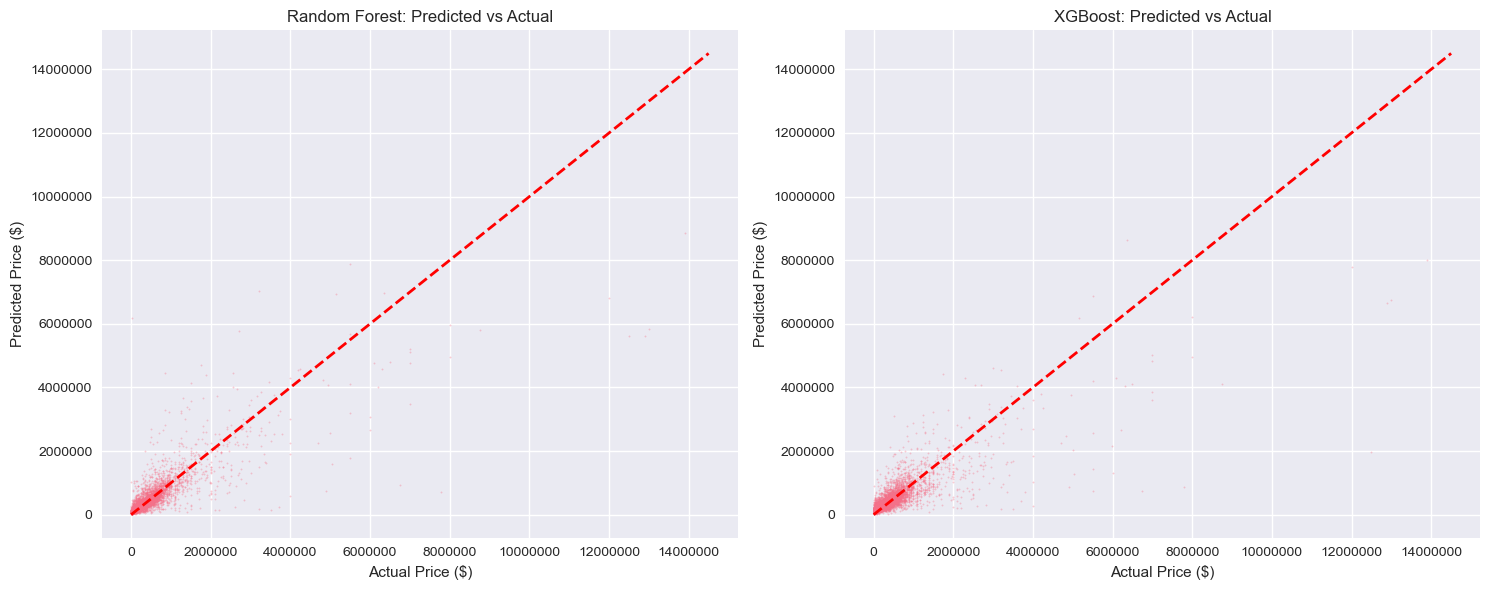

In [26]:
# Predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RF predictions
sample_indices = np.random.choice(len(y_test), min(5000, len(y_test)), replace=False)
axes[0].scatter(y_test.iloc[sample_indices], y_pred_rf[sample_indices], alpha=0.3, s=1)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title('Random Forest: Predicted vs Actual')
axes[0].ticklabel_format(style='plain', axis='both')

# XGB predictions
axes[1].scatter(y_test.iloc[sample_indices], y_pred_xgb[sample_indices], alpha=0.3, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title('XGBoost: Predicted vs Actual')
axes[1].ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()


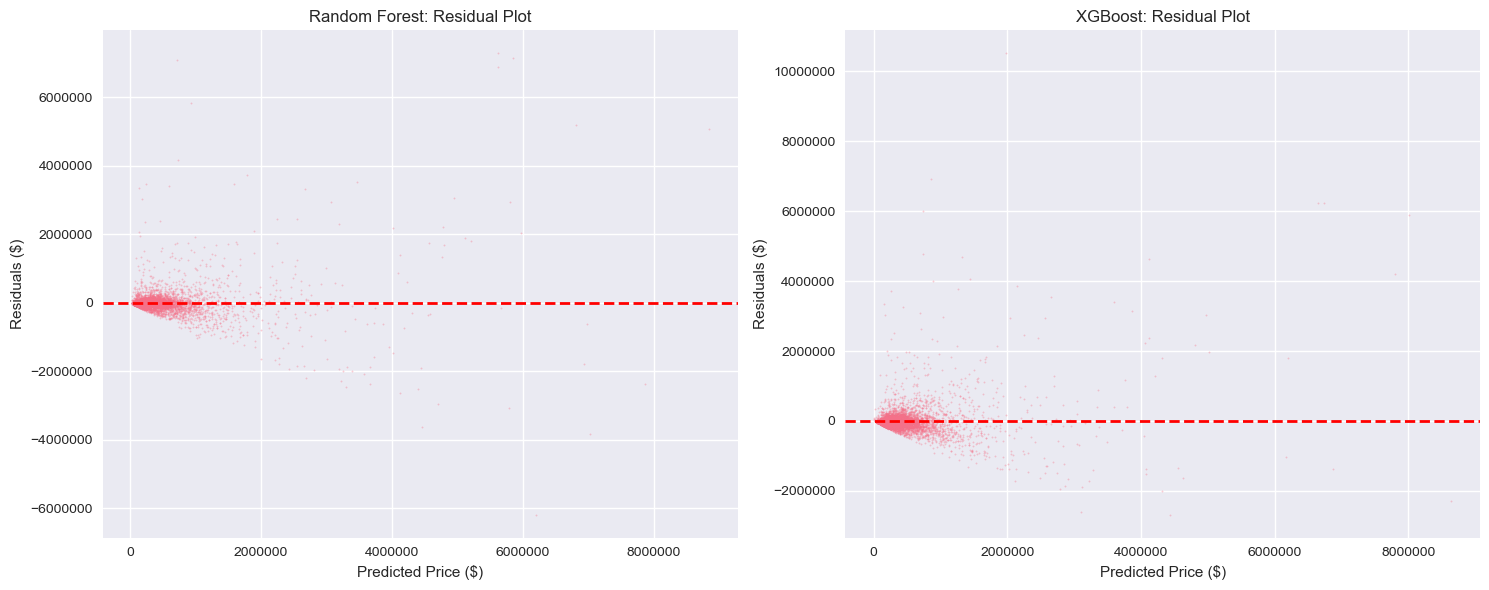

In [27]:
# Residuals
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RF predictions residuals
rf_residuals = y_test - y_pred_rf
axes[0].scatter(y_pred_rf[sample_indices], rf_residuals.iloc[sample_indices], alpha=0.3, s=1)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('Random Forest: Residual Plot')
axes[0].ticklabel_format(style='plain', axis='both')

# XGB predictions residuals
xgb_residuals = y_test - y_pred_xgb
axes[1].scatter(y_pred_xgb[sample_indices], xgb_residuals.iloc[sample_indices], alpha=0.3, s=1)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('XGBoost: Residual Plot')
axes[1].ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()


### 5.2 Observations and Analysis

Both models performed well, but a bit better results were given by XGBoost with lower RMSE and MAE and higher R²; this was expected because XGBoost usually performs well in this kind of data.

Looking at feature importance, location was both models' most important factor. The state and city frequency were the strongest predictors. House size, lot acreage, was very important, followed by the number of bedrooms and bathrooms. Status had some effect, less than location and size.

Residuals show that both struggle more with expensive properties, which is expected since those are rarer, but R² scores above 0.7 indicate that they are capturing the main patterns.

There is room for improvement: hyperparameter tuning could be tried, interaction features such as price per square foot could be created, or additional geographic data could be added. The models have their setbacks - they may not handle very extreme outliers well, nor do they account for local market conditions or recent trends.

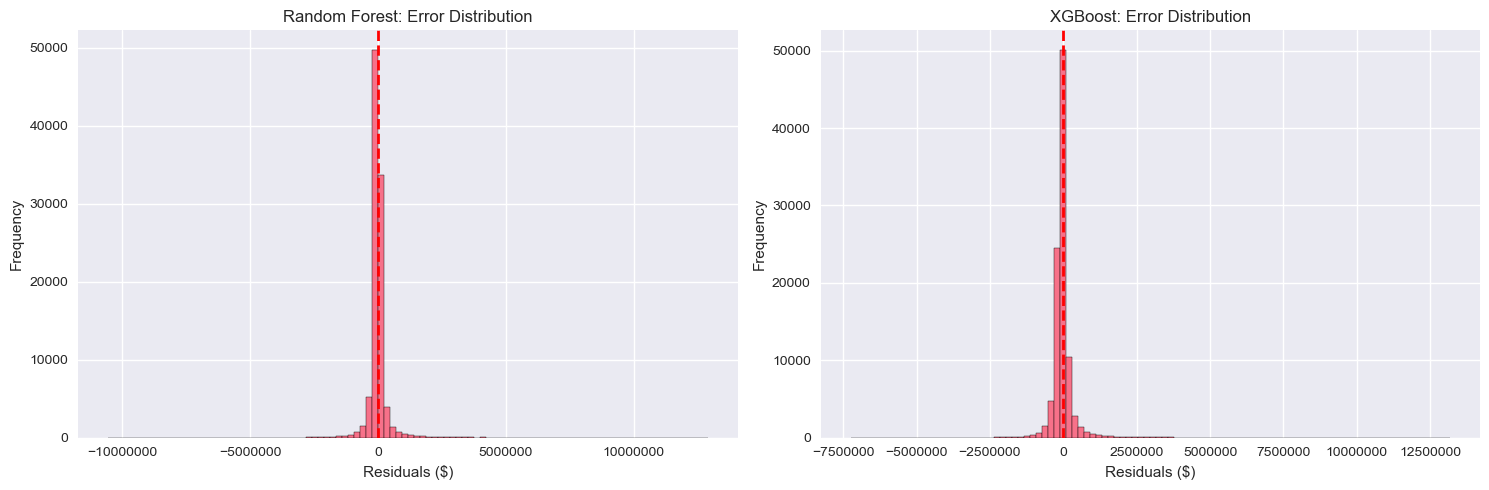


Random Forest - Mean Residual: $-6,961.32, Std: $484,390.98
XGBoost - Mean Residual: $-682.09, Std: $511,046.72


In [28]:
# Error distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RF predictions error distribution
axes[0].hist(rf_residuals, bins=100, edgecolor='black')
axes[0].set_xlabel('Residuals ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Random Forest: Error Distribution')
axes[0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0].ticklabel_format(style='plain', axis='x')

# XGB predictions error distribution
axes[1].hist(xgb_residuals, bins=100, edgecolor='black')
axes[1].set_xlabel('Residuals ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('XGBoost: Error Distribution')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

print(f"\nRandom Forest - Mean Residual: ${rf_residuals.mean():,.2f}, Std: ${rf_residuals.std():,.2f}")
print(f"XGBoost - Mean Residual: ${xgb_residuals.mean():,.2f}, Std: ${xgb_residuals.std():,.2f}")


## 6 Conclusions

### 6.1 Summary

Two machine learning models have been developed and tested for real estate pricing. Both the Random Forest and XGBoost fared well, although XGBoost slightly outperformed. The models captured relationships between location, size, bedrooms, bathrooms, and prices.

### 6.2 Key Learnings

This project provided several insights. Powerful ensemble methods like Random Forest and XGBoost for regression with big data are able to find nonlinear relationships that other simpler models cannot find.

Feature engineering matters: encoding categorical variables and treating missing values made a huge difference. Location was the most important factor, which is expected.

Data quality was essential: cleaning, handling outliers, and dealing with missing values needed to be appropriate. Utilizing various metrics such as RMSE, MAE, and R² was more telling than using just one metric.

### 6.3 Challenges and Solutions

The biggest problem was the size of the dataset; 2.2 million samples is quite large. A sample of 500,000 was used to keep processing manageable. There were also a lot of missing values in house_size and acre_lot.

These problems were addressed by using sampling for quicker processing, filling in missing values with median/mode, and removing extreme outliers. Parallel processing available with XGBoost also accelerated the training.

### 6.4 Future Work

If this were to be a continuing project, one could attempt hyperparameter tuning in a quest for better results. Interaction features such as price per square foot could be created. Incorporation of external data on economic indicators or school ratings might allow for better predictions. Deep learning or SHAP values are other means to better understand the models.

## 7 References

1. Breiman, L. (2001). Random forests. *Machine learning*, 45(1), 5-32.

2. Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In *Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining* (pp. 785-794).

3. Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. *Journal of machine learning research*, 12, 2825-2830.

4. Ahmedshahriarsakib. (2024). USA Real Estate Dataset. *Kaggle*. https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset


## 8 Acknowledgements

Thanks to the resources that helped with this project.

The USA Real Estate Dataset from Kaggle was used. When coding issues were encountered, Stack Overflow and GitHub provided helpful solutions. The scikit-learn and XGBoost documentation helped in understanding how to use the libraries.

I used AI tools to help with code debugging, understanding library documentation, and refining the writing style of this report. The AI was used as a tool to assist with technical questions and writing improvements, but all analysis, results interpretation, model selection, and conclusions are my own work.

## 9 Source Code

The complete source code for this project is available on GitHub:

**GitHub Repository**: https://github.com/AbbadCha/real-estate-price-prediction

**Instructions to run:**
1. Clone the repository
2. Install requirements: `pip install -r requirements.txt`
3. Download the dataset from Kaggle: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
4. Place the dataset in the `data/` directory
5. Open and run `notebooks/real-estate-price-prediction.ipynb` in Jupyter Notebook

---

**End of Report**
